# CausalInference Tutorial
> "In this tutorial we're going to cover techniques like Inverse Propensity Score, Matching, Doubly Robust Weighted Estimator, Trimming and Stratification."

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [causality, jupyter]
- image: images/causal.png
- hide: false

We want to measure the effect of smoking cessation on weight gain using the National Health and Nutrition Examionation Survey Epidemiologic Followup Study (NHEFS) dataset. This study was driven for 11 years (1971-1982). Each subject was weighted twice. The first one was at the begining of the experiment (1971) and the second one, at the end of this experiment in 1982.

## Import libraries

In [1]:
import pandas as pd
from causalinference import CausalModel
import seaborn as sns
import matplotlib as plt
import numpy as np
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load data

In [3]:
data = pd.read_csv("https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/1268/20/nhefs.csv")

## Exploratory Data Analysis

In [4]:
data.columns

Index(['seqn', 'qsmk', 'death', 'yrdth', 'modth', 'dadth', 'sbp', 'dbp', 'sex',
       'age', 'race', 'income', 'marital', 'school', 'education', 'ht', 'wt71',
       'wt82', 'wt82_71', 'birthplace', 'smokeintensity', 'smkintensity82_71',
       'smokeyrs', 'asthma', 'bronch', 'tb', 'hf', 'hbp', 'pepticulcer',
       'colitis', 'hepatitis', 'chroniccough', 'hayfever', 'diabetes', 'polio',
       'tumor', 'nervousbreak', 'alcoholpy', 'alcoholfreq', 'alcoholtype',
       'alcoholhowmuch', 'pica', 'headache', 'otherpain', 'weakheart',
       'allergies', 'nerves', 'lackpep', 'hbpmed', 'boweltrouble', 'wtloss',
       'infection', 'active', 'exercise', 'birthcontrol', 'pregnancies',
       'cholesterol', 'hightax82', 'price71', 'price82', 'tax71', 'tax82',
       'price71_82', 'tax71_82'],
      dtype='object')

In [5]:
data.shape

(1629, 64)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1629 entries, 0 to 1628
Data columns (total 64 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               1629 non-null   int64  
 1   qsmk               1629 non-null   int64  
 2   death              1629 non-null   int64  
 3   yrdth              318 non-null    float64
 4   modth              322 non-null    float64
 5   dadth              322 non-null    float64
 6   sbp                1552 non-null   float64
 7   dbp                1548 non-null   float64
 8   sex                1629 non-null   int64  
 9   age                1629 non-null   int64  
 10  race               1629 non-null   int64  
 11  income             1567 non-null   float64
 12  marital            1629 non-null   int64  
 13  school             1629 non-null   int64  
 14  education          1629 non-null   int64  
 15  ht                 1629 non-null   float64
 16  wt71               1629 

In [9]:
data.head()

,seqn,qsmk,death,yrdth,modth,dadth,sbp,dbp,sex,age,race,income,marital,school,education,ht,wt71,wt82,wt82_71,birthplace,smokeintensity,smkintensity82_71,smokeyrs,asthma,bronch,tb,hf,hbp,pepticulcer,colitis,hepatitis,chroniccough,hayfever,diabetes,polio,tumor,nervousbreak,alcoholpy,alcoholfreq,alcoholtype,alcoholhowmuch,pica,headache,otherpain,weakheart,allergies,nerves,lackpep,hbpmed,boweltrouble,wtloss,infection,active,exercise,birthcontrol,pregnancies,cholesterol,hightax82,price71,price82,tax71,tax82,price71_82,tax71_82
0,233,0,0,NaN,NaN,NaN,175.0,96.0,0,42,1,19.0,2,7,1,174.1875,79.04,68.946040,-10.093960,47.0,30,-10,29,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,1,3,7.0,0,1,0,0,0,0,0,1,0,0,0,0,2,2,NaN,197.0,0.0,2.183594,1.739990,1.102295,0.461975,0.443787,0.640381
1,235,0,0,NaN,NaN,NaN,123.0,80.0,0,36,0,18.0,2,9,2,159.3750,58.63,61.234970,2.604970,42.0,20,-10,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,4.0,0,1,0,0,0,0,0,0,0,0,1,0,0,2,NaN,301.0,0.0,2.346680,1.797363,1.364990,0.571899,0.549316,0.792969
2,244,0,0,NaN,NaN,NaN,115.0,75.0,1,56,1,15.0,3,11,2,168.5000,56.81,66.224486,9.414486,51.0,20,-14,26,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,3,4,NaN,0,1,1,0,0,1,0,0,0,0,0,0,2,0,2.0,157.0,0.0,1.569580,1.513428,0.551270,0.230988,0.056198,0.320251
3,245,0,1,85.0,2.0,14.0,148.0,78.0,0,68,1,15.0,3,5,1,170.1875,59.42,64.410117,4.990117,37.0,3,4,53,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,3,4.0,0,0,1,1,0,0,0,0,0,0,0,1,2,2,NaN,174.0,0.0,1.506592,1.451904,0.524902,0.219971,0.054794,0.304993
4,252,0,0,NaN,NaN,NaN,118.0,77.0,0,40,0,18.0,2,11,2,181.8750,87.09,92.079251,4.989251,42.0,20,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,2.0,0,1,0,0,0,0,0,0,1,0,0,1,1,2,NaN,216.0,0.0,2.346680,1.797363,1.364990,0.571899,0.549316,0.792969


In [10]:
data.describe()

,seqn,qsmk,death,yrdth,modth,dadth,sbp,dbp,sex,age,race,income,marital,school,education,ht,wt71,wt82,wt82_71,birthplace,smokeintensity,smkintensity82_71,smokeyrs,asthma,bronch,tb,hf,hbp,pepticulcer,colitis,hepatitis,chroniccough,hayfever,diabetes,polio,tumor,nervousbreak,alcoholpy,alcoholfreq,alcoholtype,alcoholhowmuch,pica,headache,otherpain,weakheart,allergies,nerves,lackpep,hbpmed,boweltrouble,wtloss,infection,active,exercise,birthcontrol,pregnancies,cholesterol,hightax82,price71,price82,tax71,tax82,price71_82,tax71_82
count,1629.000000,1629.000000,1629.000000,318.000000,322.000000,322.000000,1552.000000,1548.000000,1629.000000,1629.000000,1629.000000,1567.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.00000,1566.000000,1566.000000,1537.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1212.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,726.00000,1613.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000
mean,16552.364641,0.262738,0.195212,87.569182,6.257764,15.872671,128.709407,77.744832,0.509515,43.915285,0.131983,17.947671,2.503376,11.135052,2.703499,168.740965,71.05213,73.469219,2.638300,31.595316,20.551258,-4.737876,24.871087,0.048496,0.085328,0.014119,0.004911,1.050952,0.103745,0.033763,0.017188,0.054021,0.089626,0.979742,0.014119,0.023327,0.028852,0.875998,1.920196,2.475752,3.287129,0.975445,0.629834,0.246163,0.022099,0.062001,0.144260,0.050952,1.005525,1.034991,0.025783,0.147944,0.651934,1.195212,1.084715,3.69146,219.973962,0.165908,2.138750,1.806095,1.058581,0.505983,0.332741,0.552614
std,7498.918195,0.440256,0.396485,2.659415,3.615304,8.905488,19.051560,10.634864,0.500063,12.170430,0.338576,2.663277,1.082367,3.089601,1.190098,9.053131,15.72959,16.158047,7.879913,14.500500,11.803754,13.741360,12.198072,0.214878,0.279456,0.118018,0.069928,0.958209,0.305023,0.180674,0.130013,0.226128,0.285732,0.995793,0.118018,0.150987,0.167442,0.338873,1.307140,1.208155,2.984695,0.997853,0.482997,0.430907,0.147052,0.241232,0.351461,0.219966,0.982947,0.967216,0.158535,0.355153,0.652742,0.739348,0.947747,2.20560,45.444202,0.372119,0.229016,0.130641,0.216229,0.111894,0.155045,0.150321
min,233.000000,0.000000,0.000000,83.000000,1.000000,1.000000,87.000000,47.000000,0.000000,25.000000,0.000000,11.000000,2.000000,0.000000,1.000000,142.875000,36.17000,35.380205,-41.280470,1.000000,1.000000,-80.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,78.000000,0.000000,1.506592,1.451904,0.524902,0.219971,-0.202698,0.035995
25%,10607.000000,0.000000,0.000000,85.000000,3.000000,8.000000,116.000000,70.000000,0.000000,33.000000,0.000000,17.000000,2.000000,10.000000,2.000000,161.781250,59.65000,61.688562,-1.478399,22.000000,10.000000,-10.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.00000,189.000000,0.000000,2.036621,1.739990,0.944946,0.439941,0.200989,0.460999
50%,20333.000000,0.000000,0.000000,88.000000,6.000000,15.500000,126.000000,77.000000,1.000000,44.000000,0.000000,19.000000,2.000000,12.000000,3.000000,168.281250,69.40000,72.121187,2.603811,34.000000,20.000000,-1.000000,24.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [11]:
data.isnull().sum()

seqn                    0
qsmk                    0
death                   0
yrdth                1311
modth                1307
dadth                1307
sbp                    77
dbp                    81
sex                     0
age                     0
race                    0
income                 62
marital                 0
school                  0
education               0
ht                      0
wt71                    0
wt82                   63
wt82_71                63
birthplace             92
smokeintensity          0
smkintensity82_71       0
smokeyrs                0
asthma                  0
bronch                  0
tb                      0
hf                      0
hbp                     0
pepticulcer             0
colitis                 0
hepatitis               0
chroniccough            0
hayfever                0
diabetes                0
polio                   0
tumor                   0
nervousbreak            0
alcoholpy               0
alcoholfreq 

### Assumption

We're going to remove people who haven't survived until the end of the experiment in 1982. We can check this fact testing if the field called 'wt82' has some value. It stands for the weight measured at 1982.

In [12]:
data = data.dropna(subset=['wt82'])
data.shape

(1566, 64)

### Covariates, Treatment and Outcome variables

From https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/1268/20/hernanrobins_v2.17.21.pdf <br><br>
Our goal is to estimate the average causal effect of smoking cessation (the treatment) A on weight gain (the outcome) Y.  To do so, we will use data from 1566 cigarette smokers aged 25-74 years who, as part of the NHEFS, had a baseline visit and a follow-up visit about 10 years later.

* The <b>treatment</b> variable (<b>A</b>) is `qsmk` (quit smoking). Individuals were classified as treated A=1 if they reported having quit smoking before the follow-up visit, and as untreated A=0 otherwise.

In [13]:
data['qsmk'].value_counts(ascending=True)

1     403
0    1163
Name: qsmk, dtype: int64

In [14]:
data.qsmk.value_counts(normalize=True)

0    0.742656
1    0.257344
Name: qsmk, dtype: float64

In [15]:
A = data['qsmk']

* The <b>outcome</b> variable (<b>Y</b>) is `wt82_71` (the individual's body weight at the follow-up visit in 1982 minus the individual's body weight at the baseline visit in 1971). 

In [16]:
data['wt82_71'].value_counts()

 3.057111     3
-4.085807     2
 2.947008     2
 6.232155     2
 3.745454     2
-3.966775     2
 0.227008     2
-7.145221     2
 5.445556     2
-1.020851     2
 3.061378     2
 1.131187     2
-3.176877     2
 2.836231     2
 5.098855     2
-2.490851     2
 5.215747     2
 1.362932     2
 4.080894     2
 3.512741     2
-0.117450     2
 7.595161     2
 0.225072     2
-1.252112     2
-0.568138     2
-1.585221     2
 0.910703     2
 2.384486     2
-2.270265     2
 0.002932     2
 3.514970     2
-1.591819     2
 7.256333     2
 0.909149     2
 4.532932     2
-2.378916     2
 6.348078     2
 8.962932     2
 4.989530     2
-5.443667     2
 1.020703     2
 7.596333     2
-0.451144     2
 0.798078     2
 4.539823     2
 4.650410     2
-1.929297     2
-13.381335    2
-0.113183     2
 6.805072     2
 2.834105     2
 0.908856     2
 5.101964     2
 9.295366     2
 13.044779    2
-3.405412     1
 5.443327     1
 7.936817     1
 7.706817     1
 8.163900     1
 0.340410     1
 3.854486     1
-4.08473

In [17]:
Y = data['wt82_71']

* The <b>confounding</b> variables (<b>X</b>) (variables that influence both the independent variables and dependent variable causing spurious correlations) will be:

In [18]:
cf = ["active",          # Measure of daily activity on 1971.
      "age",             # Age in 1971.
      "education",       # Amount of education in 1971: from 8th-grade to college level education.
      "exercise",        # Measure of recreational excercise.
      "race",            # Caucasian or not.
      "sex",             # Female or male.
      "smokeintensity",  # Number of Cigarettes smoked per day in 1971.  
      "smokeyrs",        # Years of smoking.
      "wt71"             # Weight in Kilograms in 1971.
    
]
X = data[cf]

In [19]:
print(X.shape)
X.head()

(1566, 9)


,active,age,education,exercise,race,sex,smokeintensity,smokeyrs,wt71
0,0,42,1,2,1,0,30,29,79.04
1,0,36,2,0,0,0,20,24,58.63
2,0,56,2,2,1,1,20,26,56.81
3,1,68,1,2,1,0,3,53,59.42
4,1,40,2,1,0,0,20,19,87.09


In [20]:
X['active'].value_counts()

1    715
0    702
2    149
Name: active, dtype: int64

In [21]:
X['exercise'].value_counts()

1    661
2    605
0    300
Name: exercise, dtype: int64

In [22]:
X['education'].value_counts()

3    637
2    340
1    291
5    177
4    121
Name: education, dtype: int64

* <b>Distribution</b> of the <b>outcome</b> in relation to the <b>control</b> and <b>treatment</b> groups

In [23]:
data[data.qsmk==0].wt82_71.count()

1163

In [24]:
data[data.qsmk==1].wt82_71.count()

403

We have a very imbalanced dataset with 1163 samples for the control group and 403 samples for the treatment group

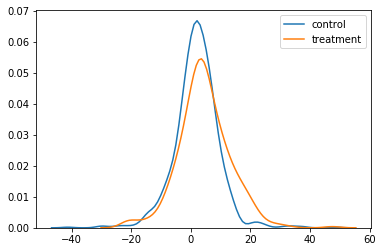

In [22]:
sns.kdeplot(data.loc[lambda df: df.qsmk==0].wt82_71, label='control')
sns.kdeplot(data.loc[lambda df: df.qsmk==1].wt82_71, label='treatment')

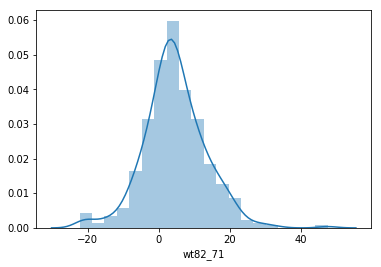

In [34]:
sns.distplot(data[data.qsmk==1]['wt82_71'], bins=20)


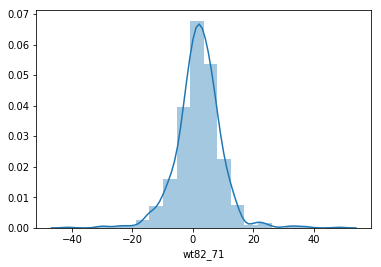

In [35]:
sns.distplot(data[data.qsmk==0]['wt82_71'], bins=20)

qsmk
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: wt82_71, dtype: object

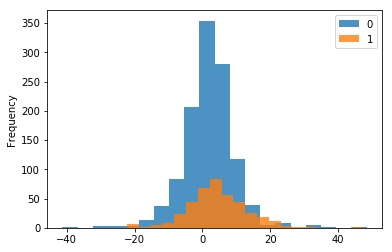

In [36]:
data.groupby('qsmk')['wt82_71'].plot(kind='hist', bins=20, alpha=0.8, legend=True)

In [37]:
data.groupby('qsmk')['wt82_71'].agg(['mean', 'median'])

,mean,median
qsmk,,
0,1.984498,2.151084
1,4.525079,3.971582


The mean weight gain value for the treatment group is greater than the mean value for the control group. Could we think that the treatment had a postive impact (more weight for subjects who quit smoking)? We have to remember that the dataset is imbalanced.

* <b>Distribution</b> of several <b>covariates</b> in relation to the <b>control</b> and <b>treatment</b> groups

qsmk
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

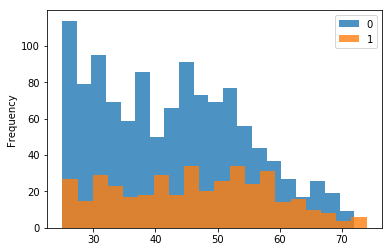

In [38]:
data.groupby('qsmk')['age'].plot(kind='hist', bins=20, alpha=0.8, legend=True)

qsmk
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: education, dtype: object

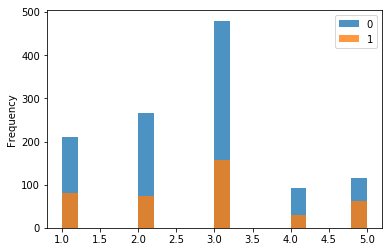

In [39]:
data.groupby('qsmk')['education'].plot(kind='hist', bins=20, alpha=0.8, legend=True)

qsmk
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: active, dtype: object

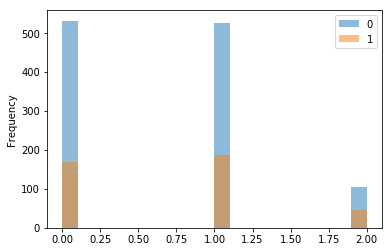

In [40]:
data.groupby('qsmk')['active'].plot(kind='hist', bins=20, alpha=0.5, legend=True)

qsmk
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: exercise, dtype: object

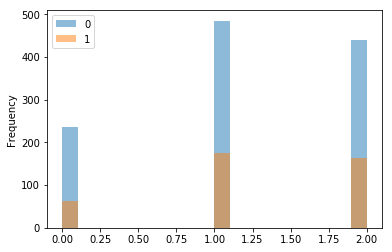

In [41]:
data.groupby('qsmk')['exercise'].plot(kind='hist', bins=20, alpha=0.5, legend=True)

## Causal Inference Analysis

### Potential Outcomes

Y = Y(0) when A = 0<br><br>
Y = Y(1) when A = 1

### Goal

We want to estimate the <b>ATE</b> so the real ATE measured in a Randomized Controlled Trial (interventional distribution) can be defined as:<br><br> Δreal = E[Y(1) - Y(0)] <br><br>But if we want to compute it from observational data:<br><br> Δobs = E[Y|A=1] - E[Y|A=0] = E[Y(1)|A=1] - E[Y(0)|A=0] <> Δreal<br><br> because <br><br>E[Y(i)|X=i] <> E[Y(i)].<br><br>

### Assumption

Ignorability assumption: The treatment (A) received  by a sample is totally explained by the random variable(s) X and the output is independent from the treatment assignment A. <br><br>
Y(0), Y(1) ⊥ A|X <br><br>
P(A,Y(0),Y(1)|X) = P(A|X)*P(Y(0),Y(1)|X)<br><br>
The treatment is assumed to be unconfounded in the sense that the dependence between the treatment assignment and the outcomes is only through something we observe, namely the covariates X.


### ATE using Linear Model

We're going to assume that:<br><br>
Y(0) = α+βX+ϵ<br><br>
where ϵ (residual) represents the noise (Y(0) doesn't have the treatment variable A) and<br><br>
Y(1) = Y(0)+γA<br><br>
So we can estimate the ATE as:<br><br>
Y = α+βX+γA<br><br>

In [42]:
model = CausalModel(Y=data.wt82_71.values, D=data.qsmk.values, X=X.values)

The parameter <b>adj</b> indicates how covariate adjustments are to be performed. Set adj = 0 to not include any covariates. Set adj = 1 to include treatment indicator D and covariates X separately. Set adj = 2 to additionally include interaction terms between D and X. Defaults to 2.

In [43]:
model.est_via_ols(adj=1)

/home/eldar/.conda/envs/causal/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


In [44]:
print(model.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      3.349      0.473      7.084      0.000      2.422      4.275



The estimated ATE is 3.349 (postive weight gain in relation to the treatment of giving up smoking). If our model decribes accurately the confounders X, we got a 95% confidence interval (If we repeat 100 times the experiment, the predicted ATE would be inside of that interval in 95 times. But the real ATE could be outside of that interval).<br><br>
95 % Confidence Interval = AVG ± 1.96 * np.sqrt(data[data[A]==1].wt82_71.var()/data[data.[A]==1].shape[0] + data[data[A]==0].wt82_71.var()/data[data[A]==0].shape[0])

### ATE via Matching

For each sample we're going to take the most similar one from the other ttreatment group (control) and we're going to estimate the ATE using them. To decide what's the meaning of the most similar one we're going to choose the Nearest neighbourg from the X covariate space, weighting the distances using the inverse of the variance of each covariate.

In [45]:
model = CausalModel(Y=data.wt82_71.values, D=data.qsmk.values, X=X.values)

In [46]:
model.est_via_matching()

In [47]:
print(model.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      3.612      0.760      4.751      0.000      2.122      5.102
           ATC      3.643      0.829      4.395      0.000      2.018      5.268
           ATT      3.523      0.860      4.096      0.000      1.837      5.208



<b>ATC (Average Treatment Effect of the Control) = </b> E[Y(1) - Y(0)|X=0]<br><br>
<b>ATT (Average Treatment Effect of the Treated) = </b> E[Y(1) - Y(0)|X=1]

The parameter <b>matches</b> stands for the number of matches to use for each subject and the parameter <b>bias_adj</b> indicates whether bias adjustements should be attempted. https://www.ncbi.nlm.nih.gov/books/NBK424728/)

In [50]:
model.est_via_matching(weights='inv', matches=2)
print(model.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      3.499      0.634      5.519      0.000      2.256      4.741
           ATC      3.567      0.681      5.240      0.000      2.233      4.902
           ATT      3.301      0.668      4.941      0.000      1.991      4.610



In [48]:
model.est_via_matching(weights='inv', matches=2, bias_adj=True)

/home/eldar/.conda/envs/causal/lib/python3.6/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


In [49]:
print(model.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      3.686      0.633      5.822      0.000      2.445      4.927
           ATC      3.654      0.680      5.372      0.000      2.321      4.987
           ATT      3.781      0.666      5.676      0.000      2.475      5.086



### Propensity

e(X) = P(A|X)

### ATE via Inverse Propensity Score Weighting Estimator

We want to know the value of the Potential Outcomes E[Y(i)] but using observational data we can only have access to E[Y(i)| X=i].<br><br>
The probability of the Potential Outcomes can be defined as:<br><br>
P(Y(i)) = P(Y(i)|X=i)*P(X=i)<br><br>
So we could think that we could compute:<br><br>
$$E(Y(i)) = E[\frac{yi}{P(A|X)}*P(A|X)]$$<br><br>
If we multiply each sample times its inverse propensity score we could compute the Potential Outcomes.

#### Inverse Propensity Score Weighting Estimator

$$ΔIPSW = 1/N * (\sum_{i=Treatment} \frac{yi}{e(Xi)} - \sum_{i=Control} \frac{yi}{1-e(Xi)})$$

In [51]:
model = CausalModel(Y=data.wt82_71.values, D=data.qsmk.values, X=X.values)

The <b>est_propensity_s()</b> method applies a Logistic Regression over the covariates.

In [52]:
model.est_propensity_s()

In [53]:
propensity = model.propensity['fitted']

In [55]:
df = data
df['ips'] = np.where(df.qsmk == 1, 1/propensity, 1/(1-propensity))

In [56]:
df['ipsw'] = df.wt82_71 * df['ips']

In [58]:
ipswe = (df[df.qsmk==1]['ipsw'].sum() - df[df.qsmk==0]['ipsw'].sum())/df.shape[0]

In [63]:
print('The estimated ATE computed using IPSWE is: ' + str(ipswe))

The estimated ATE computed using IPSWE is: 3.555669650974593


### Overlap of Treatment and Control Groups in the Covariates Space

In [64]:
model = CausalModel(Y=data.wt82_71.values, D=data.qsmk.values, X=X.values)

In [66]:
print(model.summary_stats)


Summary Statistics

                      Controls (N_c=1163)         Treated (N_t=403)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        1.984        7.449        4.525        8.748        2.541

                      Controls (N_c=1163)         Treated (N_t=403)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.632        0.642        0.690        0.662        0.089
             X1       42.788       11.792       46.174       12.215        0.282
             X2        2.687        1.153        2.794        1.279        0.088
             X3        1.175        0.743        1.251        0.708        0.104
             X4        0.146        0.353        0.089        0.286       -0.177
      

Large values indicate that simple linear adjustment methods may not be adequate for removing biases that are associated with differences in covariates.

### ATE via Doubly Robust Weighted Estimator

We're going to estimate the ATE computing a weighted Linear Regression, weighting each sample using the inverse propensity score.

In [67]:
model = CausalModel(Y=data.wt82_71.values, D=data.qsmk.values, X=X.values)

In [68]:
model.est_propensity_s()
model.est_via_weighting()

/home/eldar/.conda/envs/causal/lib/python3.6/site-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


In [69]:
print(model.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      3.877      0.482      8.036      0.000      2.932      4.823



### ATE via Trimming

The <b>trim_s()</b> method is going to remove samples whose estimated propensity score <= cutoff or >= (1 - cutoff).

In [71]:
model = CausalModel(Y=data.wt82_71.values, D=data.qsmk.values, X=X.values)

In [72]:
model.est_propensity_s()
model.trim_s()
model.est_via_matching()

In [73]:
print(model.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      3.689      0.768      4.801      0.000      2.183      5.194
           ATC      3.817      0.833      4.582      0.000      2.184      5.449
           ATT      3.342      0.880      3.797      0.000      1.617      5.067



In [74]:
propensity = model.propensity['fitted']
cutoff = model.cutoff

In [80]:
print(propensity)

[0.09731427 0.14588255 0.14901795 ... 0.12258264 0.46821307 0.15911705]


In [79]:
print(cutoff)

0.09465076523563337


In [75]:
mask = (propensity > cutoff) & (propensity < 1 - cutoff)

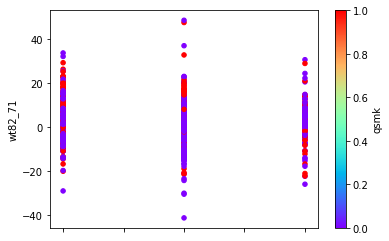

In [78]:
data[mask].plot.scatter(x='active', y='wt82_71', c='qsmk', cmap='rainbow', colorbar=True)

### ATE via Stratification

If we don't have a prior knowledge about what 'similar samples' could be, we can group these samples inside clusters of similar propensity scores. After that, we can compute the ATE of each cluster of subjects.

In [81]:
model = CausalModel(Y=data.wt82_71.values, D=data.qsmk.values, X=X.values)

In [82]:
model.est_propensity_s()
model.stratify_s()

In [84]:
print(model.strata)


Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.033     0.127       179        18     0.093     0.096     2.147
         2     0.127     0.172       167        29     0.149     0.152     4.979
         3     0.172     0.243       302        89     0.209     0.212     3.742
         4     0.243     0.281       152        44     0.261     0.263     6.632
         5     0.281     0.332       130        65     0.303     0.303     1.482
         6     0.332     0.393       126        70     0.361     0.361     3.631
         7     0.393     0.450        65        33     0.417     0.418     2.358
         8     0.450     0.508        28        21     0.473     0.480     3.195
         9     0.509     0.865        14        34     0.579     0.590     1.466



We can compute the overall ATE from the different strata using the <b>est_via_blocking</b> method. To achive that, this function estimates average treatment effects using regression within blocks.

In [85]:
model.est_via_blocking()

/home/eldar/.conda/envs/causal/lib/python3.6/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


In [86]:
print(model.estimates)


Treatment Effect Estimates: Blocking

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      3.625      0.482      7.515      0.000      2.680      4.571
           ATC      3.667      0.511      7.177      0.000      2.666      4.668
           ATT      3.505      0.466      7.517      0.000      2.591      4.418

